In [1]:
# ===============================
# 0. Setup & Imports
# ===============================
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops

from tqdm import tqdm

2025-05-11 16:59:02.198814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746982742.401432      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746982742.455856      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
# ===============================
# 1. Parameters & Paths
# ===============================
dataset_path = '/kaggle/input/mit-ib1/MIT-IB'  # adjust path if needed
img_size = (224, 224)
MAX_IMAGES_PER_CLASS = 440  # number of original images to use per class

In [11]:
# ===============================
# 2. Helper Functions
# ===============================
def load_images_and_labels(base_path):
    data = []
    labels = []
    for label_name, label_value in [('male1', 0), ('female', 1)]:
        folder = os.path.join(base_path, label_name)
        for filename in os.listdir(folder):
            path = os.path.join(folder, filename)
            if path.lower().endswith(('.png', '.jpg', '.jpeg')):
                data.append((path, label_value))
    return data


In [12]:
def augment_image(img):
    flipped = cv2.flip(img, 1)
    rows, cols = img.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 15, 1)
    rotated = cv2.warpAffine(img, M, (cols, rows))
    return [img, flipped, rotated]


In [13]:
def preprocess_gray(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    return img

In [14]:
def extract_low_level_features(img_gray):
    hog_feat = hog(img_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

    lbp = local_binary_pattern(img_gray, P=8, R=1, method="uniform")
    (hist_lbp, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    hist_lbp = hist_lbp.astype("float")
    hist_lbp /= (hist_lbp.sum() + 1e-6)

    glcm = graycomatrix(img_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    glcm_feats = [contrast, homogeneity, energy]

    return np.hstack([hog_feat, hist_lbp, glcm_feats])

In [15]:
def extract_deep_feature(img_path, model):
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)
    return feature.flatten()

In [16]:
# ===============================
# 3. Load & Augment Data
# ===============================
print("Loading and augmenting images...")
data = load_images_and_labels(dataset_path)
augmented_imgs = []
augmented_labels = []

class_counts = {0: 0, 1: 0}

for path, label in tqdm(data):
    if class_counts[label] >= MAX_IMAGES_PER_CLASS:
        continue
    img = preprocess_gray(path)
    for aug in augment_image(img):
        augmented_imgs.append(aug)
        augmented_labels.append(label)
    class_counts[label] += 1
    if all(c >= MAX_IMAGES_PER_CLASS for c in class_counts.values()):
        break

augmented_labels = np.array(augmented_labels)


Loading and augmenting images...


100%|██████████| 888/888 [00:02<00:00, 315.19it/s]


In [17]:
# ===============================
# 4. Extract Features
# ===============================
print("Extracting features...")

vgg = VGG19(weights='imagenet', include_top=True)
vgg_fc7 = Model(inputs=vgg.input, outputs=vgg.get_layer('fc2').output)

low_feats = []
high_feats = []

for i in tqdm(range(len(augmented_imgs))):
    gray_img = augmented_imgs[i]
    low_feat = extract_low_level_features(gray_img)
    low_feats.append(low_feat)

    temp_path = f"/content/temp_{i}.jpg"
    cv2.imwrite(temp_path, cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR))
    deep_feat = extract_deep_feature(temp_path, vgg_fc7)
    high_feats.append(deep_feat)
    os.remove(temp_path)

Extracting features...
574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


  0%|          | 0/2184 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1746983514.663916      97 service.cc:148] XLA service 0x7d60d4004730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746983514.664747      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746983514.664767      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746983514.813130      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1746983517.346820      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
  0%|          | 1/2184 [00:03<2:03:09,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|          | 3/2184 [00:03<34:32,  1.05it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 5/2184 [00:03<18:32,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|          | 6/2184 [00:03<14:33,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 8/2184 [00:04<09:42,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|          | 10/2184 [00:04<07:17,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|          | 12/2184 [00:04<05:56,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 14/2184 [00:04<05:13,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 16/2184 [00:04<04:38,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 18/2184 [00:05<04:30,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|          | 19/2184 [00:05<04:28,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  1%|          | 20/2184 [00:05<05:08,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 21/2184 [00:05<04:59,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 22/2184 [00:05<04:51,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  1%|          | 23/2184 [00:05<04:49,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|          | 24/2184 [00:05<05:05,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 25/2184 [00:06<04:59,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 26/2184 [00:06<04:38,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|          | 27/2184 [00:06<04:24,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▏         | 28/2184 [00:06<04:16,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▏         | 29/2184 [00:06<04:07,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▏         | 30/2184 [00:06<03:58,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▏         | 31/2184 [00:06<03:51,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▏         | 32/2184 [00:06<03:48,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 33/2184 [00:06<03:46,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|▏         | 34/2184 [00:07<03:43,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 35/2184 [00:07<03:44,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 36/2184 [00:07<03:43,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 37/2184 [00:07<03:42,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 38/2184 [00:07<03:43,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 39/2184 [00:07<03:41,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 40/2184 [00:07<03:40,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 41/2184 [00:07<03:40,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 42/2184 [00:07<03:40,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 43/2184 [00:07<03:42,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 44/2184 [00:08<03:41,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 45/2184 [00:08<03:39,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 46/2184 [00:08<03:38,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 47/2184 [00:08<03:43,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 48/2184 [00:08<03:44,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 49/2184 [00:08<03:43,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 50/2184 [00:08<03:43,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 51/2184 [00:08<03:44,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 52/2184 [00:08<03:44,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 53/2184 [00:08<03:42,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 54/2184 [00:09<03:41,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 55/2184 [00:09<03:40,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 56/2184 [00:09<03:40,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 57/2184 [00:09<03:40,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 58/2184 [00:09<03:40,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 59/2184 [00:09<03:41,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 60/2184 [00:09<03:40,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 61/2184 [00:09<03:39,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 62/2184 [00:09<03:38,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 63/2184 [00:10<03:38,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 64/2184 [00:10<03:38,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 65/2184 [00:10<03:40,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 66/2184 [00:10<03:40,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 67/2184 [00:10<03:41,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 68/2184 [00:10<03:41,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 69/2184 [00:10<03:41,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|▎         | 70/2184 [00:10<03:43,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 71/2184 [00:10<03:46,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 72/2184 [00:10<03:46,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 73/2184 [00:11<03:45,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 74/2184 [00:11<03:46,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 75/2184 [00:11<03:46,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 76/2184 [00:11<03:48,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▎         | 77/2184 [00:11<03:50,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▎         | 78/2184 [00:11<03:51,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▎         | 79/2184 [00:11<03:49,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▎         | 80/2184 [00:11<03:48,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▎         | 81/2184 [00:11<03:50,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▍         | 82/2184 [00:12<03:52,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 83/2184 [00:12<03:54,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▍         | 84/2184 [00:12<03:50,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▍         | 85/2184 [00:12<03:47,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▍         | 86/2184 [00:12<03:45,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▍         | 87/2184 [00:12<03:42,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▍         | 88/2184 [00:12<03:41,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▍         | 89/2184 [00:12<03:39,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▍         | 90/2184 [00:12<03:38,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▍         | 91/2184 [00:13<03:37,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▍         | 92/2184 [00:13<03:36,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▍         | 93/2184 [00:13<03:36,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▍         | 94/2184 [00:13<03:37,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▍         | 95/2184 [00:13<03:41,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▍         | 96/2184 [00:13<03:41,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▍         | 97/2184 [00:13<03:38,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▍         | 98/2184 [00:13<03:37,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 99/2184 [00:13<03:49,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▍         | 100/2184 [00:14<03:58,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▍         | 101/2184 [00:14<03:55,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 102/2184 [00:14<03:56,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▍         | 103/2184 [00:14<03:56,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 104/2184 [00:14<03:58,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 105/2184 [00:14<03:56,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|▍         | 106/2184 [00:14<03:58,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▍         | 107/2184 [00:14<03:51,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▍         | 108/2184 [00:14<03:46,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▍         | 109/2184 [00:15<03:44,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▌         | 110/2184 [00:15<03:42,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▌         | 111/2184 [00:15<03:41,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▌         | 112/2184 [00:15<03:39,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▌         | 113/2184 [00:15<03:38,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▌         | 114/2184 [00:15<03:36,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▌         | 115/2184 [00:15<03:36,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▌         | 116/2184 [00:15<03:36,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▌         | 117/2184 [00:15<03:34,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▌         | 118/2184 [00:15<03:33,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▌         | 119/2184 [00:16<03:35,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▌         | 120/2184 [00:16<03:35,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▌         | 121/2184 [00:16<03:34,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▌         | 122/2184 [00:16<03:34,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▌         | 123/2184 [00:16<03:33,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▌         | 124/2184 [00:16<03:33,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 125/2184 [00:16<03:32,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▌         | 126/2184 [00:16<03:31,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 127/2184 [00:16<03:30,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▌         | 128/2184 [00:16<03:30,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 129/2184 [00:17<03:31,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 130/2184 [00:17<03:37,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 131/2184 [00:17<03:48,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 132/2184 [00:17<03:46,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 133/2184 [00:17<03:43,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 134/2184 [00:17<03:41,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 135/2184 [00:17<03:40,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▌         | 136/2184 [00:17<03:37,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▋         | 137/2184 [00:17<03:37,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▋         | 138/2184 [00:18<03:36,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|▋         | 139/2184 [00:18<03:33,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▋         | 140/2184 [00:18<03:31,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▋         | 141/2184 [00:18<03:31,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 142/2184 [00:18<03:30,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 143/2184 [00:18<03:33,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 144/2184 [00:18<03:31,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 145/2184 [00:18<03:31,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 146/2184 [00:18<03:30,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 147/2184 [00:18<03:31,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 148/2184 [00:19<03:30,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 149/2184 [00:19<03:28,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 150/2184 [00:19<03:29,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 151/2184 [00:19<03:28,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 152/2184 [00:19<03:28,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 153/2184 [00:19<03:27,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 154/2184 [00:19<03:27,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 155/2184 [00:19<03:29,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 156/2184 [00:19<03:29,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 157/2184 [00:20<03:28,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 158/2184 [00:20<03:28,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 159/2184 [00:20<03:29,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 160/2184 [00:20<03:28,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 161/2184 [00:20<03:28,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 162/2184 [00:20<03:27,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 163/2184 [00:20<03:29,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 164/2184 [00:20<03:31,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 165/2184 [00:20<03:31,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 166/2184 [00:20<03:31,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 167/2184 [00:21<03:31,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 168/2184 [00:21<03:29,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 169/2184 [00:21<03:28,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 170/2184 [00:21<03:29,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 171/2184 [00:21<03:28,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 172/2184 [00:21<03:28,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 173/2184 [00:21<03:27,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 174/2184 [00:21<03:26,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 175/2184 [00:21<03:27,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 176/2184 [00:21<03:27,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 177/2184 [00:22<03:28,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 178/2184 [00:22<03:28,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 179/2184 [00:22<03:28,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 180/2184 [00:22<03:31,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 181/2184 [00:22<03:30,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 182/2184 [00:22<03:29,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 183/2184 [00:22<03:28,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 184/2184 [00:22<03:26,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 185/2184 [00:22<03:25,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▊         | 186/2184 [00:23<03:25,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▊         | 187/2184 [00:23<03:25,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▊         | 188/2184 [00:23<03:24,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▊         | 189/2184 [00:23<03:24,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▊         | 190/2184 [00:23<03:25,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▊         | 191/2184 [00:23<03:26,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 192/2184 [00:23<03:25,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 193/2184 [00:23<03:24,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 194/2184 [00:23<03:24,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 195/2184 [00:23<03:24,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 196/2184 [00:24<03:23,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 197/2184 [00:24<03:23,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 198/2184 [00:24<03:22,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 199/2184 [00:24<03:24,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 200/2184 [00:24<03:26,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 201/2184 [00:24<03:33,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 202/2184 [00:24<03:37,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 203/2184 [00:24<03:34,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 204/2184 [00:24<03:31,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 205/2184 [00:25<03:29,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 206/2184 [00:25<03:28,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 207/2184 [00:25<03:28,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|▉         | 208/2184 [00:25<03:26,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|▉         | 209/2184 [00:25<03:25,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|▉         | 210/2184 [00:25<03:25,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|▉         | 211/2184 [00:25<03:24,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|▉         | 212/2184 [00:25<03:24,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|▉         | 213/2184 [00:25<03:24,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|▉         | 214/2184 [00:25<03:23,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|▉         | 215/2184 [00:26<03:25,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|▉         | 216/2184 [00:26<03:24,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|▉         | 217/2184 [00:26<03:23,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|▉         | 218/2184 [00:26<03:25,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|█         | 219/2184 [00:26<03:25,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|█         | 220/2184 [00:26<03:24,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|█         | 221/2184 [00:26<03:24,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|█         | 222/2184 [00:26<03:23,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|█         | 223/2184 [00:26<03:23,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|█         | 224/2184 [00:26<03:22,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|█         | 225/2184 [00:27<03:21,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|█         | 226/2184 [00:27<03:22,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█         | 227/2184 [00:27<03:25,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█         | 228/2184 [00:27<03:25,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|█         | 229/2184 [00:27<03:24,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 230/2184 [00:27<03:24,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 231/2184 [00:27<03:24,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 232/2184 [00:27<03:22,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 233/2184 [00:27<03:21,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 234/2184 [00:28<03:21,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 235/2184 [00:28<03:20,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 237/2184 [00:28<03:18,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 238/2184 [00:28<03:19,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 239/2184 [00:28<03:22,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 240/2184 [00:28<03:21,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 241/2184 [00:28<03:21,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 242/2184 [00:28<03:22,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 243/2184 [00:28<03:21,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 244/2184 [00:29<03:21,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 245/2184 [00:29<03:20,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█▏        | 246/2184 [00:29<03:19,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█▏        | 247/2184 [00:29<03:18,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█▏        | 248/2184 [00:29<03:18,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█▏        | 249/2184 [00:29<03:20,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█▏        | 250/2184 [00:29<03:19,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█▏        | 251/2184 [00:29<03:20,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 252/2184 [00:29<03:19,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 253/2184 [00:29<03:19,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 254/2184 [00:30<03:20,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 255/2184 [00:30<03:19,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 256/2184 [00:30<03:19,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 257/2184 [00:30<03:18,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 258/2184 [00:30<03:19,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 259/2184 [00:30<03:18,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 260/2184 [00:30<03:18,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 261/2184 [00:30<03:17,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 262/2184 [00:30<03:16,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 263/2184 [00:31<03:17,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 264/2184 [00:31<03:17,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 265/2184 [00:31<03:17,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 266/2184 [00:31<03:18,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 267/2184 [00:31<03:18,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 268/2184 [00:31<03:17,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 269/2184 [00:31<03:17,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 270/2184 [00:31<03:16,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 271/2184 [00:31<03:15,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 272/2184 [00:31<03:15,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▎        | 273/2184 [00:32<03:15,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 274/2184 [00:32<03:18,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█▎        | 275/2184 [00:32<03:20,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 276/2184 [00:32<03:21,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█▎        | 277/2184 [00:32<03:20,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 278/2184 [00:32<03:20,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 279/2184 [00:32<03:19,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 280/2184 [00:32<03:18,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 281/2184 [00:32<03:16,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 282/2184 [00:32<03:16,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█▎        | 283/2184 [00:33<03:16,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 284/2184 [00:33<03:16,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 285/2184 [00:33<03:15,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 286/2184 [00:33<03:15,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█▎        | 287/2184 [00:33<03:17,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 288/2184 [00:33<03:18,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 289/2184 [00:33<03:16,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█▎        | 290/2184 [00:33<03:15,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 291/2184 [00:33<03:15,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 292/2184 [00:34<03:14,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 293/2184 [00:34<03:13,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 294/2184 [00:34<03:11,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▎        | 295/2184 [00:34<03:13,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▎        | 296/2184 [00:34<03:16,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▎        | 297/2184 [00:34<03:19,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▎        | 298/2184 [00:34<03:34,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▎        | 299/2184 [00:34<03:30,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▎        | 300/2184 [00:34<03:25,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 301/2184 [00:34<03:21,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 302/2184 [00:35<03:19,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 303/2184 [00:35<03:17,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 14%|█▍        | 304/2184 [00:35<03:15,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 305/2184 [00:35<03:15,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 306/2184 [00:35<03:14,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 307/2184 [00:35<03:14,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 308/2184 [00:35<03:14,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 309/2184 [00:35<03:13,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 310/2184 [00:35<03:13,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 311/2184 [00:36<03:14,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 312/2184 [00:36<03:14,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 313/2184 [00:36<03:13,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 314/2184 [00:36<03:12,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 315/2184 [00:36<03:12,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 316/2184 [00:36<03:14,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|█▍        | 317/2184 [00:36<03:31,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 318/2184 [00:36<03:29,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 319/2184 [00:36<03:35,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▍        | 320/2184 [00:37<03:32,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 321/2184 [00:37<03:27,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 322/2184 [00:37<03:24,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 323/2184 [00:37<03:30,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▍        | 324/2184 [00:37<03:26,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▍        | 325/2184 [00:37<03:23,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 326/2184 [00:37<03:21,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▍        | 327/2184 [00:37<03:22,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 328/2184 [00:37<03:23,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 329/2184 [00:37<03:19,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 330/2184 [00:38<03:17,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 331/2184 [00:38<03:15,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 332/2184 [00:38<03:13,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 333/2184 [00:38<03:13,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 334/2184 [00:38<03:13,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 335/2184 [00:38<03:14,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 336/2184 [00:38<03:14,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 337/2184 [00:38<03:12,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 338/2184 [00:38<03:11,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 339/2184 [00:39<03:11,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 340/2184 [00:39<03:14,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 341/2184 [00:39<03:12,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▌        | 342/2184 [00:39<03:11,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 343/2184 [00:39<03:10,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 344/2184 [00:39<03:10,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 345/2184 [00:39<03:10,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▌        | 346/2184 [00:39<03:11,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 347/2184 [00:39<03:12,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▌        | 348/2184 [00:39<03:11,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▌        | 349/2184 [00:40<03:11,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 350/2184 [00:40<03:13,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 351/2184 [00:40<03:13,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 352/2184 [00:40<03:12,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 353/2184 [00:40<03:11,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 354/2184 [00:40<03:09,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▋        | 355/2184 [00:40<03:12,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▋        | 356/2184 [00:40<03:10,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▋        | 357/2184 [00:40<03:09,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▋        | 358/2184 [00:41<03:08,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▋        | 359/2184 [00:41<03:09,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▋        | 360/2184 [00:41<03:08,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 361/2184 [00:41<03:09,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 362/2184 [00:41<03:10,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 363/2184 [00:41<03:13,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 364/2184 [00:41<03:11,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 365/2184 [00:41<03:11,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 366/2184 [00:41<03:10,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 367/2184 [00:41<03:10,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 368/2184 [00:42<03:08,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 369/2184 [00:42<03:07,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 370/2184 [00:42<03:08,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 371/2184 [00:42<03:09,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 372/2184 [00:42<03:09,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 373/2184 [00:42<03:09,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 374/2184 [00:42<03:08,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 375/2184 [00:42<03:08,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 376/2184 [00:42<03:08,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 377/2184 [00:42<03:09,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 378/2184 [00:43<03:10,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 379/2184 [00:43<03:09,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 380/2184 [00:43<03:08,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 381/2184 [00:43<03:08,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 382/2184 [00:43<03:08,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 383/2184 [00:43<03:09,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 384/2184 [00:43<03:08,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 385/2184 [00:43<03:08,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 386/2184 [00:43<03:08,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 387/2184 [00:44<03:08,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 388/2184 [00:44<03:06,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 389/2184 [00:44<03:07,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 390/2184 [00:44<03:07,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 391/2184 [00:44<03:12,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 392/2184 [00:44<03:12,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 393/2184 [00:44<03:15,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 394/2184 [00:44<03:13,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█▊        | 395/2184 [00:44<03:14,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 396/2184 [00:45<03:13,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 397/2184 [00:45<03:10,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█▊        | 398/2184 [00:45<03:09,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 399/2184 [00:45<03:08,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 400/2184 [00:45<03:06,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█▊        | 401/2184 [00:45<03:06,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 402/2184 [00:45<03:05,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 403/2184 [00:45<03:05,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 404/2184 [00:45<03:03,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▊        | 405/2184 [00:45<03:03,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▊        | 406/2184 [00:46<03:02,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▊        | 407/2184 [00:46<03:04,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▊        | 408/2184 [00:46<03:03,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▊        | 409/2184 [00:46<03:03,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▉        | 410/2184 [00:46<03:04,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 411/2184 [00:46<03:04,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 412/2184 [00:46<03:04,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 413/2184 [00:46<03:03,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 414/2184 [00:46<03:02,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 415/2184 [00:46<03:02,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 416/2184 [00:47<03:01,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 417/2184 [00:47<03:01,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 418/2184 [00:47<03:01,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▉        | 419/2184 [00:47<03:03,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▉        | 420/2184 [00:47<03:03,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 421/2184 [00:47<03:03,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▉        | 422/2184 [00:47<03:02,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▉        | 423/2184 [00:47<03:02,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▉        | 424/2184 [00:47<03:02,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 425/2184 [00:48<03:01,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|█▉        | 426/2184 [00:48<03:01,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|█▉        | 427/2184 [00:48<03:01,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|█▉        | 428/2184 [00:48<03:01,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|█▉        | 429/2184 [00:48<03:01,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|█▉        | 430/2184 [00:48<03:01,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|█▉        | 431/2184 [00:48<03:03,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|█▉        | 432/2184 [00:48<03:03,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|█▉        | 433/2184 [00:48<03:02,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|█▉        | 434/2184 [00:48<03:02,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|█▉        | 435/2184 [00:49<03:00,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|█▉        | 436/2184 [00:49<03:00,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 437/2184 [00:49<02:59,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|██        | 438/2184 [00:49<03:00,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 439/2184 [00:49<03:00,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 440/2184 [00:49<03:00,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 441/2184 [00:49<03:00,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 442/2184 [00:49<03:00,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|██        | 443/2184 [00:49<03:02,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 444/2184 [00:49<03:02,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 445/2184 [00:50<03:01,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 446/2184 [00:50<03:01,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 447/2184 [00:50<03:00,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 448/2184 [00:50<03:00,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|██        | 449/2184 [00:50<02:59,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 450/2184 [00:50<02:59,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 451/2184 [00:50<02:59,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 452/2184 [00:50<02:59,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 453/2184 [00:50<02:58,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██        | 454/2184 [00:51<03:00,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 455/2184 [00:51<03:00,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 456/2184 [00:51<02:59,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██        | 457/2184 [00:51<02:59,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 458/2184 [00:51<02:58,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 459/2184 [00:51<02:59,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|██        | 460/2184 [00:51<02:59,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██        | 461/2184 [00:51<03:01,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██        | 462/2184 [00:51<03:05,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 463/2184 [00:51<03:03,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 464/2184 [00:52<03:02,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██▏       | 465/2184 [00:52<03:01,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██▏       | 466/2184 [00:52<02:59,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██▏       | 467/2184 [00:52<03:01,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██▏       | 468/2184 [00:52<03:00,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██▏       | 469/2184 [00:52<02:59,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 470/2184 [00:52<02:58,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 471/2184 [00:52<02:57,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 472/2184 [00:52<02:58,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 473/2184 [00:53<02:58,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 474/2184 [00:53<02:57,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 475/2184 [00:53<02:56,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 476/2184 [00:53<02:55,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 477/2184 [00:53<02:54,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 478/2184 [00:53<02:55,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 479/2184 [00:53<02:56,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 480/2184 [00:53<02:55,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 481/2184 [00:53<02:56,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 482/2184 [00:53<02:55,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 483/2184 [00:54<02:55,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 484/2184 [00:54<02:54,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 485/2184 [00:54<02:54,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 486/2184 [00:54<02:54,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 487/2184 [00:54<03:00,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 22%|██▏       | 488/2184 [00:54<03:07,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 489/2184 [00:54<03:14,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 490/2184 [00:54<03:09,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 491/2184 [00:54<03:13,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 492/2184 [00:55<03:09,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 493/2184 [00:55<03:06,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 494/2184 [00:55<03:04,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 495/2184 [00:55<03:06,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 23%|██▎       | 496/2184 [00:55<03:12,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 497/2184 [00:55<03:18,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 498/2184 [00:55<03:14,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 499/2184 [00:55<03:15,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 500/2184 [00:55<03:12,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 501/2184 [00:56<03:11,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 502/2184 [00:56<03:08,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 503/2184 [00:56<03:12,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 504/2184 [00:56<03:12,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 505/2184 [00:56<03:21,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 506/2184 [00:56<03:44,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 507/2184 [00:56<03:32,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 508/2184 [00:56<03:22,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 509/2184 [00:57<03:16,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 510/2184 [00:57<03:11,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 511/2184 [00:57<03:16,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 512/2184 [00:57<03:14,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 513/2184 [00:57<03:12,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 24%|██▎       | 514/2184 [00:57<03:19,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▎       | 515/2184 [00:57<03:15,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▎       | 516/2184 [00:57<03:16,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▎       | 517/2184 [00:57<03:16,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▎       | 518/2184 [00:58<03:09,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 519/2184 [00:58<03:09,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██▍       | 520/2184 [00:58<03:08,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 521/2184 [00:58<03:07,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 522/2184 [00:58<03:03,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 523/2184 [00:58<03:00,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▍       | 524/2184 [00:58<03:00,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██▍       | 525/2184 [00:58<03:00,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 526/2184 [00:58<02:58,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 527/2184 [00:59<03:01,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 528/2184 [00:59<03:00,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 529/2184 [00:59<03:04,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 530/2184 [00:59<03:05,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 531/2184 [00:59<03:02,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 532/2184 [00:59<03:05,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 533/2184 [00:59<03:04,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 534/2184 [00:59<03:02,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 535/2184 [00:59<03:01,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▍       | 536/2184 [01:00<03:01,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 25%|██▍       | 537/2184 [01:00<03:05,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▍       | 538/2184 [01:00<03:03,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▍       | 539/2184 [01:00<03:02,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▍       | 540/2184 [01:00<02:59,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▍       | 541/2184 [01:00<02:56,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▍       | 542/2184 [01:00<02:55,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▍       | 543/2184 [01:00<02:54,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▍       | 544/2184 [01:00<02:53,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▍       | 545/2184 [01:01<02:51,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▌       | 546/2184 [01:01<02:49,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▌       | 547/2184 [01:01<02:50,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▌       | 548/2184 [01:01<02:49,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▌       | 549/2184 [01:01<02:48,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▌       | 550/2184 [01:01<02:49,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▌       | 551/2184 [01:01<02:50,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▌       | 552/2184 [01:01<02:50,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▌       | 553/2184 [01:01<02:49,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▌       | 554/2184 [01:01<02:49,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▌       | 555/2184 [01:02<02:48,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▌       | 556/2184 [01:02<02:49,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 557/2184 [01:02<02:48,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 558/2184 [01:02<02:48,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 559/2184 [01:02<02:47,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 560/2184 [01:02<02:48,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 561/2184 [01:02<02:48,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 562/2184 [01:02<02:47,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 563/2184 [01:02<02:48,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 564/2184 [01:02<02:47,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 565/2184 [01:03<02:47,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 566/2184 [01:03<02:47,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 567/2184 [01:03<02:46,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 568/2184 [01:03<02:47,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 569/2184 [01:03<02:47,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 570/2184 [01:03<02:47,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 571/2184 [01:03<02:48,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 572/2184 [01:03<02:48,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 573/2184 [01:03<02:47,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▋       | 574/2184 [01:04<02:46,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▋       | 575/2184 [01:04<02:47,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▋       | 576/2184 [01:04<02:46,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▋       | 577/2184 [01:04<02:46,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▋       | 578/2184 [01:04<02:49,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 579/2184 [01:04<02:48,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 580/2184 [01:04<02:55,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 581/2184 [01:04<02:52,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 582/2184 [01:04<02:50,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 583/2184 [01:04<02:48,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 584/2184 [01:05<02:46,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 585/2184 [01:05<02:45,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 586/2184 [01:05<02:47,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 587/2184 [01:05<02:47,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 588/2184 [01:05<02:45,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 589/2184 [01:05<02:46,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 590/2184 [01:05<02:45,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 591/2184 [01:05<02:45,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 592/2184 [01:05<02:44,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 593/2184 [01:06<02:44,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 594/2184 [01:06<02:43,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 27%|██▋       | 595/2184 [01:06<02:42,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 596/2184 [01:06<02:42,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 597/2184 [01:06<02:41,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 598/2184 [01:06<02:41,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 599/2184 [01:06<02:43,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 600/2184 [01:06<02:43,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██▊       | 601/2184 [01:06<02:43,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██▊       | 602/2184 [01:06<02:43,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 603/2184 [01:07<02:43,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 604/2184 [01:07<02:42,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██▊       | 605/2184 [01:07<02:42,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██▊       | 606/2184 [01:07<02:42,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██▊       | 607/2184 [01:07<02:42,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 608/2184 [01:07<02:43,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 609/2184 [01:07<02:42,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██▊       | 610/2184 [01:07<02:42,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 611/2184 [01:07<02:43,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██▊       | 612/2184 [01:07<02:43,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 613/2184 [01:08<02:53,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 614/2184 [01:08<02:56,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 28%|██▊       | 615/2184 [01:08<03:02,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 616/2184 [01:08<03:04,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 617/2184 [01:08<03:04,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 618/2184 [01:08<02:58,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 619/2184 [01:08<02:54,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 620/2184 [01:08<02:51,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 621/2184 [01:09<02:48,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 622/2184 [01:09<02:47,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▊       | 623/2184 [01:09<02:47,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▊       | 624/2184 [01:09<02:48,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▊       | 625/2184 [01:09<02:48,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▊       | 626/2184 [01:09<02:46,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▊       | 627/2184 [01:09<02:46,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 628/2184 [01:09<02:44,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 629/2184 [01:09<02:42,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 630/2184 [01:09<02:41,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 631/2184 [01:10<02:41,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 632/2184 [01:10<02:41,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 633/2184 [01:10<02:40,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 634/2184 [01:10<02:40,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 635/2184 [01:10<02:41,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 636/2184 [01:10<02:42,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 637/2184 [01:10<02:40,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 638/2184 [01:10<02:39,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 639/2184 [01:10<02:39,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 640/2184 [01:10<02:39,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 641/2184 [01:11<02:39,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 642/2184 [01:11<02:39,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 643/2184 [01:11<02:38,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 644/2184 [01:11<02:37,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██▉       | 645/2184 [01:11<02:37,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██▉       | 646/2184 [01:11<02:37,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██▉       | 647/2184 [01:11<02:38,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██▉       | 648/2184 [01:11<02:43,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██▉       | 649/2184 [01:11<02:42,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██▉       | 650/2184 [01:12<02:41,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██▉       | 651/2184 [01:12<02:40,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██▉       | 652/2184 [01:12<02:40,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██▉       | 653/2184 [01:12<02:39,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██▉       | 654/2184 [01:12<02:38,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██▉       | 655/2184 [01:12<02:38,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███       | 656/2184 [01:12<02:37,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 657/2184 [01:12<02:37,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 658/2184 [01:12<02:38,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███       | 659/2184 [01:12<02:39,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███       | 660/2184 [01:13<02:39,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 661/2184 [01:13<02:38,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 662/2184 [01:13<02:37,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███       | 663/2184 [01:13<02:37,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 664/2184 [01:13<02:39,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 665/2184 [01:13<02:40,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███       | 666/2184 [01:13<02:39,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███       | 667/2184 [01:13<02:39,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███       | 668/2184 [01:13<02:38,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███       | 669/2184 [01:14<02:36,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███       | 670/2184 [01:14<02:35,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███       | 671/2184 [01:14<02:36,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 672/2184 [01:14<02:37,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 673/2184 [01:14<02:38,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 674/2184 [01:14<02:39,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 675/2184 [01:14<02:49,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 676/2184 [01:14<02:46,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 677/2184 [01:14<02:45,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 678/2184 [01:14<02:43,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 679/2184 [01:15<02:41,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 680/2184 [01:15<02:40,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███       | 681/2184 [01:15<02:39,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███       | 682/2184 [01:15<02:37,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███▏      | 683/2184 [01:15<02:37,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███▏      | 684/2184 [01:15<02:36,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███▏      | 685/2184 [01:15<02:37,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███▏      | 686/2184 [01:15<02:37,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███▏      | 687/2184 [01:15<02:36,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 688/2184 [01:16<02:35,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 689/2184 [01:16<02:35,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 690/2184 [01:16<02:34,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 691/2184 [01:16<02:34,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 692/2184 [01:16<02:34,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 693/2184 [01:16<02:34,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 694/2184 [01:16<02:34,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 695/2184 [01:16<02:37,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 696/2184 [01:16<02:37,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 697/2184 [01:16<02:35,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 698/2184 [01:17<02:38,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 699/2184 [01:17<02:36,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 700/2184 [01:17<02:38,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 701/2184 [01:17<02:42,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 702/2184 [01:17<02:38,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 703/2184 [01:17<02:37,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 704/2184 [01:17<02:36,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 705/2184 [01:17<02:35,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 706/2184 [01:17<02:36,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 707/2184 [01:18<02:35,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 708/2184 [01:18<02:34,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 709/2184 [01:18<02:33,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 710/2184 [01:18<02:32,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 711/2184 [01:18<02:31,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 712/2184 [01:18<02:31,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 713/2184 [01:18<02:32,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 714/2184 [01:18<02:31,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 715/2184 [01:18<02:30,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 716/2184 [01:18<02:29,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 717/2184 [01:19<02:29,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 718/2184 [01:19<02:28,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 719/2184 [01:19<02:30,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 720/2184 [01:19<02:30,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 721/2184 [01:19<02:30,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 722/2184 [01:19<02:31,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 723/2184 [01:19<02:31,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 724/2184 [01:19<02:30,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 725/2184 [01:19<02:29,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 726/2184 [01:19<02:29,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 727/2184 [01:20<02:28,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 728/2184 [01:20<02:28,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 729/2184 [01:20<02:27,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 730/2184 [01:20<02:27,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 731/2184 [01:20<02:29,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▎      | 732/2184 [01:20<02:30,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▎      | 733/2184 [01:20<02:30,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▎      | 734/2184 [01:20<02:29,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▎      | 735/2184 [01:20<02:29,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▎      | 736/2184 [01:21<02:29,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▎      | 737/2184 [01:21<02:28,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▍      | 738/2184 [01:21<02:28,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▍      | 739/2184 [01:21<02:28,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 740/2184 [01:21<02:28,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 741/2184 [01:21<02:29,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▍      | 742/2184 [01:21<02:31,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 743/2184 [01:21<02:34,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 744/2184 [01:21<02:34,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 745/2184 [01:21<02:32,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▍      | 746/2184 [01:22<02:31,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 747/2184 [01:22<02:31,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 748/2184 [01:22<02:30,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▍      | 749/2184 [01:22<02:30,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▍      | 750/2184 [01:22<02:30,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▍      | 751/2184 [01:22<02:28,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▍      | 752/2184 [01:22<02:27,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▍      | 753/2184 [01:22<02:27,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▍      | 754/2184 [01:22<02:30,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▍      | 755/2184 [01:23<02:36,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▍      | 756/2184 [01:23<02:37,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▍      | 757/2184 [01:23<02:37,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▍      | 758/2184 [01:23<02:42,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▍      | 759/2184 [01:23<02:41,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▍      | 760/2184 [01:23<02:39,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▍      | 761/2184 [01:23<02:37,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▍      | 762/2184 [01:23<02:42,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▍      | 763/2184 [01:23<02:38,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▍      | 764/2184 [01:24<02:38,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 765/2184 [01:24<02:36,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 766/2184 [01:24<02:38,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▌      | 767/2184 [01:24<02:38,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 768/2184 [01:24<02:41,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 35%|███▌      | 769/2184 [01:24<02:52,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 770/2184 [01:24<02:46,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 771/2184 [01:24<02:40,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▌      | 772/2184 [01:24<02:35,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 773/2184 [01:25<02:33,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▌      | 774/2184 [01:25<02:31,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▌      | 775/2184 [01:25<02:28,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 776/2184 [01:25<02:30,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███▌      | 777/2184 [01:25<02:28,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 778/2184 [01:25<02:28,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 779/2184 [01:25<02:29,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 780/2184 [01:25<02:32,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 781/2184 [01:25<02:31,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 782/2184 [01:25<02:33,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 783/2184 [01:26<02:36,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 784/2184 [01:26<02:35,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|███▌      | 785/2184 [01:26<02:36,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 786/2184 [01:26<02:33,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 787/2184 [01:26<02:31,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███▌      | 788/2184 [01:26<02:29,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 789/2184 [01:26<02:28,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███▌      | 790/2184 [01:26<02:26,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 791/2184 [01:26<02:27,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▋      | 792/2184 [01:27<02:30,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|███▋      | 793/2184 [01:27<02:34,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▋      | 794/2184 [01:27<02:43,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▋      | 795/2184 [01:27<02:45,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▋      | 796/2184 [01:27<02:45,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▋      | 797/2184 [01:27<02:40,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 798/2184 [01:27<02:35,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 799/2184 [01:27<02:31,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 800/2184 [01:27<02:28,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 801/2184 [01:28<02:27,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 802/2184 [01:28<02:26,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 803/2184 [01:28<02:26,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 804/2184 [01:28<02:25,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 805/2184 [01:28<02:24,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 806/2184 [01:28<02:24,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 807/2184 [01:28<02:24,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 808/2184 [01:28<02:23,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 809/2184 [01:28<02:23,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 810/2184 [01:29<02:22,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 811/2184 [01:29<02:21,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 812/2184 [01:29<02:21,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 813/2184 [01:29<02:20,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 814/2184 [01:29<02:21,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 815/2184 [01:29<02:22,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███▋      | 816/2184 [01:29<02:23,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███▋      | 817/2184 [01:29<02:24,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 818/2184 [01:29<02:25,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 819/2184 [01:29<02:24,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 820/2184 [01:30<02:24,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 821/2184 [01:30<02:22,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 822/2184 [01:30<02:21,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 823/2184 [01:30<02:20,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 824/2184 [01:30<02:20,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 825/2184 [01:30<02:21,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 826/2184 [01:30<02:21,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 827/2184 [01:30<02:23,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 828/2184 [01:30<02:22,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 829/2184 [01:31<02:22,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 830/2184 [01:31<02:21,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 831/2184 [01:31<02:21,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 832/2184 [01:31<02:20,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 833/2184 [01:31<02:20,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 834/2184 [01:31<02:20,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 835/2184 [01:31<02:20,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|███▊      | 836/2184 [01:31<02:19,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 837/2184 [01:31<02:18,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 838/2184 [01:31<02:18,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 839/2184 [01:32<02:18,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 840/2184 [01:32<02:19,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▊      | 841/2184 [01:32<02:19,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▊      | 842/2184 [01:32<02:19,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▊      | 843/2184 [01:32<02:18,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▊      | 844/2184 [01:32<02:18,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▊      | 845/2184 [01:32<02:19,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▊      | 846/2184 [01:32<02:18,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 847/2184 [01:32<02:18,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 848/2184 [01:32<02:18,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 849/2184 [01:33<02:18,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 850/2184 [01:33<02:18,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 851/2184 [01:33<02:19,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 852/2184 [01:33<02:19,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 853/2184 [01:33<02:19,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 854/2184 [01:33<02:18,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 855/2184 [01:33<02:18,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 856/2184 [01:33<02:17,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 857/2184 [01:33<02:17,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 858/2184 [01:34<02:18,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 859/2184 [01:34<02:17,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|███▉      | 860/2184 [01:34<02:16,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 861/2184 [01:34<02:16,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 862/2184 [01:34<02:17,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███▉      | 863/2184 [01:34<02:20,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███▉      | 864/2184 [01:34<02:29,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███▉      | 865/2184 [01:34<02:32,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|███▉      | 866/2184 [01:34<02:35,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|███▉      | 867/2184 [01:35<02:34,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███▉      | 868/2184 [01:35<02:34,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███▉      | 869/2184 [01:35<02:32,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███▉      | 870/2184 [01:35<02:31,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███▉      | 871/2184 [01:35<02:27,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███▉      | 872/2184 [01:35<02:23,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███▉      | 873/2184 [01:35<02:21,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 874/2184 [01:35<02:19,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|████      | 875/2184 [01:35<02:19,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 876/2184 [01:36<02:18,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 877/2184 [01:36<02:18,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 878/2184 [01:36<02:17,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 879/2184 [01:36<02:16,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 880/2184 [01:36<02:16,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|████      | 881/2184 [01:36<02:16,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|████      | 882/2184 [01:36<02:17,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 883/2184 [01:36<02:16,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 40%|████      | 884/2184 [01:36<02:15,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 885/2184 [01:36<02:15,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 886/2184 [01:37<02:14,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 887/2184 [01:37<02:16,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 888/2184 [01:37<02:15,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 889/2184 [01:37<02:15,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 890/2184 [01:37<02:15,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 891/2184 [01:37<02:14,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 892/2184 [01:37<02:14,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 893/2184 [01:37<02:13,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 894/2184 [01:37<02:13,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 895/2184 [01:38<02:12,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 896/2184 [01:38<02:13,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 897/2184 [01:38<02:12,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 898/2184 [01:38<02:11,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 899/2184 [01:38<02:13,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 900/2184 [01:38<02:14,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████▏     | 901/2184 [01:38<02:14,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████▏     | 902/2184 [01:38<02:14,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████▏     | 903/2184 [01:38<02:14,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████▏     | 904/2184 [01:38<02:13,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████▏     | 905/2184 [01:39<02:12,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████▏     | 906/2184 [01:39<02:11,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 907/2184 [01:39<02:11,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 908/2184 [01:39<02:11,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 42%|████▏     | 909/2184 [01:39<02:14,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 910/2184 [01:39<02:18,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 911/2184 [01:39<02:23,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 912/2184 [01:39<02:20,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 913/2184 [01:39<02:23,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 914/2184 [01:40<02:27,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 915/2184 [01:40<02:29,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 916/2184 [01:40<02:25,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 917/2184 [01:40<02:20,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 918/2184 [01:40<02:18,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 919/2184 [01:40<02:16,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 920/2184 [01:40<02:15,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 921/2184 [01:40<02:16,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 922/2184 [01:40<02:16,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 923/2184 [01:41<02:16,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 924/2184 [01:41<02:13,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 925/2184 [01:41<02:12,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 926/2184 [01:41<02:12,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 927/2184 [01:41<02:11,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 928/2184 [01:41<02:11,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 929/2184 [01:41<02:11,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 930/2184 [01:41<02:10,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 931/2184 [01:41<02:09,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 932/2184 [01:41<02:09,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 933/2184 [01:42<02:08,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 934/2184 [01:42<02:09,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 935/2184 [01:42<02:11,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 936/2184 [01:42<02:10,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 937/2184 [01:42<02:10,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 938/2184 [01:42<02:10,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 939/2184 [01:42<02:09,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 940/2184 [01:42<02:09,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 941/2184 [01:42<02:08,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 942/2184 [01:42<02:08,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 943/2184 [01:43<02:08,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 944/2184 [01:43<02:08,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 945/2184 [01:43<02:07,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 946/2184 [01:43<02:06,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 947/2184 [01:43<02:08,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 948/2184 [01:43<02:07,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 949/2184 [01:43<02:08,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 950/2184 [01:43<02:08,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▎     | 951/2184 [01:43<02:07,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▎     | 952/2184 [01:44<02:07,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▎     | 953/2184 [01:44<02:07,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▎     | 954/2184 [01:44<02:07,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▎     | 955/2184 [01:44<02:06,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 956/2184 [01:44<02:12,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 957/2184 [01:44<02:10,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 958/2184 [01:44<02:14,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▍     | 959/2184 [01:44<02:13,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 960/2184 [01:44<02:11,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 961/2184 [01:44<02:09,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 962/2184 [01:45<02:07,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 963/2184 [01:45<02:07,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 964/2184 [01:45<02:06,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 965/2184 [01:45<02:06,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 966/2184 [01:45<02:06,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 967/2184 [01:45<02:07,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 968/2184 [01:45<02:08,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 969/2184 [01:45<02:07,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 44%|████▍     | 970/2184 [01:45<02:05,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 971/2184 [01:46<02:06,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|████▍     | 972/2184 [01:46<02:07,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▍     | 973/2184 [01:46<02:07,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▍     | 974/2184 [01:46<02:06,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▍     | 975/2184 [01:46<02:08,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▍     | 976/2184 [01:46<02:07,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▍     | 977/2184 [01:46<02:07,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▍     | 978/2184 [01:46<02:06,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▍     | 979/2184 [01:46<02:06,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▍     | 980/2184 [01:46<02:05,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▍     | 981/2184 [01:47<02:05,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▍     | 982/2184 [01:47<02:04,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▌     | 983/2184 [01:47<02:05,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▌     | 984/2184 [01:47<02:04,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▌     | 985/2184 [01:47<02:06,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▌     | 986/2184 [01:47<02:08,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▌     | 987/2184 [01:47<02:08,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▌     | 988/2184 [01:47<02:07,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▌     | 989/2184 [01:47<02:07,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▌     | 990/2184 [01:48<02:05,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|████▌     | 991/2184 [01:48<02:04,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▌     | 992/2184 [01:48<02:03,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▌     | 993/2184 [01:48<02:02,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▌     | 994/2184 [01:48<02:01,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 995/2184 [01:48<02:03,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 996/2184 [01:48<02:03,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 997/2184 [01:48<02:04,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▌     | 998/2184 [01:48<02:03,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▌     | 999/2184 [01:48<02:02,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 1000/2184 [01:49<02:02,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▌     | 1002/2184 [01:49<02:00,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▌     | 1003/2184 [01:49<02:00,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 1004/2184 [01:49<02:00,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▌     | 1005/2184 [01:49<02:00,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▌     | 1006/2184 [01:49<02:00,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▌     | 1007/2184 [01:49<02:01,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▌     | 1008/2184 [01:49<02:01,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 1009/2184 [01:49<02:00,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 1010/2184 [01:50<02:02,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▋     | 1011/2184 [01:50<02:02,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▋     | 1012/2184 [01:50<02:02,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▋     | 1013/2184 [01:50<02:03,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▋     | 1014/2184 [01:50<02:03,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▋     | 1015/2184 [01:50<02:02,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 1016/2184 [01:50<02:03,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 1017/2184 [01:50<02:02,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 1018/2184 [01:50<02:01,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 1019/2184 [01:51<02:02,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 1020/2184 [01:51<02:02,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 1021/2184 [01:51<02:01,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 1022/2184 [01:51<02:01,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 1023/2184 [01:51<02:01,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 1024/2184 [01:51<02:02,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 1025/2184 [01:51<02:04,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 1026/2184 [01:51<02:02,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 1027/2184 [01:51<02:02,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 1028/2184 [01:51<02:01,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 1029/2184 [01:52<02:01,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 1030/2184 [01:52<02:01,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 1031/2184 [01:52<02:01,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 1032/2184 [01:52<02:01,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 1033/2184 [01:52<02:01,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 1034/2184 [01:52<02:01,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 1035/2184 [01:52<02:02,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 1036/2184 [01:52<02:03,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 1037/2184 [01:52<02:02,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 1038/2184 [01:53<02:01,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 1039/2184 [01:53<02:00,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 1040/2184 [01:53<02:00,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 1041/2184 [01:53<01:59,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 1042/2184 [01:53<02:00,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 1043/2184 [01:53<02:01,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 1044/2184 [01:53<02:00,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 1045/2184 [01:53<02:00,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 1046/2184 [01:53<02:00,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 1047/2184 [01:53<01:58,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 1048/2184 [01:54<01:58,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 1049/2184 [01:54<01:57,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 1050/2184 [01:54<01:56,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|████▊     | 1051/2184 [01:54<01:58,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 1052/2184 [01:54<01:58,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|████▊     | 1053/2184 [01:54<02:05,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 1054/2184 [01:54<02:03,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 1055/2184 [01:54<02:02,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 1056/2184 [01:54<02:00,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 1057/2184 [01:55<01:58,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 1058/2184 [01:55<01:57,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 1059/2184 [01:55<01:57,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▊     | 1060/2184 [01:55<01:57,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▊     | 1061/2184 [01:55<01:59,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▊     | 1062/2184 [01:55<02:02,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▊     | 1063/2184 [01:55<02:01,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▊     | 1064/2184 [01:55<02:01,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 1065/2184 [01:55<01:59,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████▉     | 1066/2184 [01:56<01:58,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████▉     | 1067/2184 [01:56<01:58,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 1068/2184 [01:56<01:57,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▉     | 1069/2184 [01:56<01:56,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▉     | 1070/2184 [01:56<01:56,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 1071/2184 [01:56<01:57,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████▉     | 1072/2184 [01:56<01:56,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 1073/2184 [01:56<01:56,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████▉     | 1074/2184 [01:56<01:56,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 1075/2184 [01:56<01:56,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████▉     | 1076/2184 [01:57<01:55,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████▉     | 1077/2184 [01:57<01:54,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 1078/2184 [01:57<01:55,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 1079/2184 [01:57<01:56,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▉     | 1080/2184 [01:57<01:56,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▉     | 1081/2184 [01:57<01:57,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████▉     | 1082/2184 [01:57<01:58,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|████▉     | 1083/2184 [01:57<01:58,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|████▉     | 1084/2184 [01:57<01:57,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|████▉     | 1085/2184 [01:58<01:56,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|████▉     | 1086/2184 [01:58<01:56,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|████▉     | 1087/2184 [01:58<01:55,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|████▉     | 1088/2184 [01:58<01:55,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|████▉     | 1089/2184 [01:58<01:54,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|████▉     | 1090/2184 [01:58<01:55,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|████▉     | 1091/2184 [01:58<01:55,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████     | 1092/2184 [01:58<01:55,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 1093/2184 [01:58<01:55,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 1094/2184 [01:58<01:55,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 1095/2184 [01:59<01:54,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 1096/2184 [01:59<01:54,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 1097/2184 [01:59<01:54,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████     | 1098/2184 [01:59<01:54,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 1099/2184 [01:59<01:54,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|█████     | 1100/2184 [01:59<01:53,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████     | 1101/2184 [01:59<01:52,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 1102/2184 [01:59<01:53,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 1103/2184 [01:59<01:54,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 1104/2184 [02:00<01:53,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 1105/2184 [02:00<01:52,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 1106/2184 [02:00<01:52,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 1107/2184 [02:00<01:51,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 1108/2184 [02:00<01:51,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 1109/2184 [02:00<01:52,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 1110/2184 [02:00<01:52,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 1111/2184 [02:00<01:51,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 1112/2184 [02:00<01:50,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 1113/2184 [02:00<01:51,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 1114/2184 [02:01<01:50,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 1115/2184 [02:01<01:51,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 1116/2184 [02:01<01:51,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 1117/2184 [02:01<01:50,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 1118/2184 [02:01<01:49,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 1119/2184 [02:01<01:49,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████▏    | 1120/2184 [02:01<01:49,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████▏    | 1121/2184 [02:01<01:49,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████▏    | 1122/2184 [02:01<01:49,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████▏    | 1123/2184 [02:01<01:49,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████▏    | 1124/2184 [02:02<01:49,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|█████▏    | 1125/2184 [02:02<01:51,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 1126/2184 [02:02<01:51,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 1127/2184 [02:02<01:51,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 1128/2184 [02:02<01:52,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 1129/2184 [02:02<01:53,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 1130/2184 [02:02<01:52,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 1131/2184 [02:02<01:51,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 1132/2184 [02:02<01:51,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 1133/2184 [02:03<01:50,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 1134/2184 [02:03<01:49,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 1135/2184 [02:03<01:49,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 1136/2184 [02:03<01:48,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 1137/2184 [02:03<01:48,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 1138/2184 [02:03<01:48,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 1139/2184 [02:03<01:49,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 1140/2184 [02:03<01:49,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 1141/2184 [02:03<01:48,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 1142/2184 [02:03<01:48,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 1143/2184 [02:04<01:48,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 1144/2184 [02:04<01:48,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 1145/2184 [02:04<01:47,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 1146/2184 [02:04<01:47,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 1147/2184 [02:04<01:48,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 1148/2184 [02:04<01:52,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 1149/2184 [02:04<01:51,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 1150/2184 [02:04<01:49,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 1151/2184 [02:04<01:49,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 1152/2184 [02:05<01:48,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 1153/2184 [02:05<01:47,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 1154/2184 [02:05<01:48,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 1155/2184 [02:05<01:47,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 1156/2184 [02:05<01:46,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 1157/2184 [02:05<01:46,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 1158/2184 [02:05<01:46,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 1159/2184 [02:05<01:46,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 1160/2184 [02:05<01:45,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 1161/2184 [02:05<01:45,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 1162/2184 [02:06<01:44,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 1163/2184 [02:06<01:45,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 1164/2184 [02:06<01:45,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 1165/2184 [02:06<01:45,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████▎    | 1166/2184 [02:06<01:45,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 1167/2184 [02:06<01:45,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 1168/2184 [02:06<01:45,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▎    | 1169/2184 [02:06<01:45,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▎    | 1170/2184 [02:06<01:44,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▎    | 1171/2184 [02:06<01:44,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▎    | 1172/2184 [02:07<01:44,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▎    | 1173/2184 [02:07<01:43,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▍    | 1174/2184 [02:07<01:43,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 1175/2184 [02:07<01:44,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 1176/2184 [02:07<01:45,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 1177/2184 [02:07<01:44,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▍    | 1178/2184 [02:07<01:44,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 1179/2184 [02:07<01:44,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▍    | 1180/2184 [02:07<01:44,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▍    | 1181/2184 [02:08<01:43,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▍    | 1182/2184 [02:08<01:43,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▍    | 1183/2184 [02:08<01:42,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▍    | 1184/2184 [02:08<01:42,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 1185/2184 [02:08<01:43,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▍    | 1186/2184 [02:08<01:43,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 1187/2184 [02:08<01:44,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 1188/2184 [02:08<01:44,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 1189/2184 [02:08<01:44,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 1190/2184 [02:08<01:43,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 1191/2184 [02:09<01:43,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 1192/2184 [02:09<01:42,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████▍    | 1194/2184 [02:09<01:41,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████▍    | 1195/2184 [02:09<01:41,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████▍    | 1196/2184 [02:09<01:41,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 1197/2184 [02:09<01:41,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████▍    | 1198/2184 [02:09<01:41,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 1199/2184 [02:09<01:41,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 1200/2184 [02:09<01:41,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▍    | 1201/2184 [02:10<01:42,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 1202/2184 [02:10<01:42,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 1203/2184 [02:10<01:42,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 1204/2184 [02:10<01:42,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 1205/2184 [02:10<01:42,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████▌    | 1206/2184 [02:10<01:41,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████▌    | 1207/2184 [02:10<01:41,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████▌    | 1208/2184 [02:10<01:42,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████▌    | 1209/2184 [02:10<01:41,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▌    | 1210/2184 [02:11<01:48,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▌    | 1211/2184 [02:11<01:47,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▌    | 1212/2184 [02:11<01:47,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 1213/2184 [02:11<01:54,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 1214/2184 [02:11<01:52,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 1215/2184 [02:11<01:50,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 1216/2184 [02:11<01:48,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 1217/2184 [02:11<01:47,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▌    | 1218/2184 [02:11<01:45,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 1219/2184 [02:12<01:44,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 1220/2184 [02:12<01:43,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 1221/2184 [02:12<01:47,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▌    | 1222/2184 [02:12<01:46,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 1223/2184 [02:12<01:45,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 1224/2184 [02:12<01:44,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 1225/2184 [02:12<01:43,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▌    | 1226/2184 [02:12<01:42,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▌    | 1227/2184 [02:12<01:41,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▌    | 1228/2184 [02:13<01:40,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▋    | 1229/2184 [02:13<01:40,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▋    | 1230/2184 [02:13<01:39,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▋    | 1231/2184 [02:13<01:39,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▋    | 1232/2184 [02:13<01:39,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▋    | 1233/2184 [02:13<01:39,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 1234/2184 [02:13<01:38,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 1235/2184 [02:13<01:40,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 1236/2184 [02:13<01:39,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 1237/2184 [02:13<01:38,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 1238/2184 [02:14<01:38,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 1239/2184 [02:14<01:37,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 1240/2184 [02:14<01:38,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 1241/2184 [02:14<01:37,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 1242/2184 [02:14<01:38,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 57%|█████▋    | 1243/2184 [02:14<01:41,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 1244/2184 [02:14<01:39,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 1245/2184 [02:14<01:38,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 1246/2184 [02:14<01:39,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 1247/2184 [02:15<01:39,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 1248/2184 [02:15<01:38,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 1249/2184 [02:15<01:37,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 1250/2184 [02:15<01:37,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 1251/2184 [02:15<01:37,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 1252/2184 [02:15<01:37,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 1253/2184 [02:15<01:36,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|█████▋    | 1254/2184 [02:15<01:35,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 1255/2184 [02:15<01:35,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|█████▊    | 1256/2184 [02:15<01:35,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|█████▊    | 1257/2184 [02:16<01:35,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 1258/2184 [02:16<01:35,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 1259/2184 [02:16<01:36,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 1260/2184 [02:16<01:36,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|█████▊    | 1261/2184 [02:16<01:35,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 1262/2184 [02:16<01:35,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 1263/2184 [02:16<01:35,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|█████▊    | 1264/2184 [02:16<01:35,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|█████▊    | 1265/2184 [02:16<01:35,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|█████▊    | 1266/2184 [02:16<01:34,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|█████▊    | 1267/2184 [02:17<01:33,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 58%|█████▊    | 1268/2184 [02:17<01:33,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 1269/2184 [02:17<01:33,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 1270/2184 [02:17<01:36,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████▊    | 1271/2184 [02:17<01:40,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 1272/2184 [02:17<01:38,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 1273/2184 [02:17<01:37,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████▊    | 1274/2184 [02:17<01:37,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 1275/2184 [02:17<01:36,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 1276/2184 [02:18<01:36,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 1277/2184 [02:18<01:35,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▊    | 1278/2184 [02:18<01:34,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▊    | 1279/2184 [02:18<01:34,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▊    | 1280/2184 [02:18<01:33,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|█████▊    | 1281/2184 [02:18<01:33,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▊    | 1282/2184 [02:18<01:32,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▊    | 1283/2184 [02:18<01:34,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 1284/2184 [02:18<01:33,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 1285/2184 [02:18<01:34,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 1286/2184 [02:19<01:33,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 1287/2184 [02:19<01:33,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 1288/2184 [02:19<01:32,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 1289/2184 [02:19<01:32,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 1290/2184 [02:19<01:32,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 1291/2184 [02:19<01:32,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 1292/2184 [02:19<01:32,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 1293/2184 [02:19<01:31,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 1294/2184 [02:19<01:31,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▉    | 1295/2184 [02:20<01:32,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 1296/2184 [02:20<01:32,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 1297/2184 [02:20<01:31,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 1298/2184 [02:20<01:31,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 1299/2184 [02:20<01:31,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████▉    | 1300/2184 [02:20<01:32,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████▉    | 1301/2184 [02:20<01:32,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████▉    | 1302/2184 [02:20<01:32,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████▉    | 1303/2184 [02:20<01:32,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████▉    | 1304/2184 [02:20<01:31,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████▉    | 1305/2184 [02:21<01:31,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████▉    | 1306/2184 [02:21<01:31,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████▉    | 1307/2184 [02:21<01:31,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████▉    | 1308/2184 [02:21<01:30,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████▉    | 1309/2184 [02:21<01:30,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████▉    | 1310/2184 [02:21<01:30,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 1311/2184 [02:21<01:30,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 1312/2184 [02:21<01:30,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 1313/2184 [02:21<01:29,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 1314/2184 [02:22<01:29,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 1315/2184 [02:22<01:29,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 1316/2184 [02:22<01:30,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 1317/2184 [02:22<01:29,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 1318/2184 [02:22<01:30,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|██████    | 1319/2184 [02:22<01:31,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 1320/2184 [02:22<01:30,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 1321/2184 [02:22<01:30,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 1322/2184 [02:22<01:30,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 61%|██████    | 1323/2184 [02:22<01:32,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 1324/2184 [02:23<01:31,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████    | 1325/2184 [02:23<01:30,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████    | 1326/2184 [02:23<01:29,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████    | 1327/2184 [02:23<01:29,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████    | 1328/2184 [02:23<01:28,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████    | 1329/2184 [02:23<01:28,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 1330/2184 [02:23<01:28,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 1331/2184 [02:23<01:29,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 1332/2184 [02:23<01:29,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 1333/2184 [02:23<01:28,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████    | 1334/2184 [02:24<01:30,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 1335/2184 [02:24<01:29,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████    | 1336/2184 [02:24<01:28,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████    | 1337/2184 [02:24<01:28,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████▏   | 1338/2184 [02:24<01:28,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████▏   | 1339/2184 [02:24<01:34,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████▏   | 1340/2184 [02:24<01:32,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████▏   | 1341/2184 [02:24<01:30,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████▏   | 1342/2184 [02:24<01:29,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████▏   | 1343/2184 [02:25<01:29,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 1344/2184 [02:25<01:28,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 1345/2184 [02:25<01:28,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 1346/2184 [02:25<01:27,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 1347/2184 [02:25<01:27,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 1348/2184 [02:25<01:27,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 1349/2184 [02:25<01:27,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 1350/2184 [02:25<01:28,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 1351/2184 [02:25<01:27,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 1352/2184 [02:26<01:27,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 1353/2184 [02:26<01:26,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 1354/2184 [02:26<01:26,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 1355/2184 [02:26<01:26,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 1356/2184 [02:26<01:26,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 1357/2184 [02:26<01:25,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 1358/2184 [02:26<01:25,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 1359/2184 [02:26<01:25,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 1360/2184 [02:26<01:25,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 1361/2184 [02:26<01:26,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 1362/2184 [02:27<01:25,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 1363/2184 [02:27<01:25,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 1364/2184 [02:27<01:26,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▎   | 1365/2184 [02:27<01:25,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 1366/2184 [02:27<01:25,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 1367/2184 [02:27<01:27,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 1368/2184 [02:27<01:27,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 1369/2184 [02:27<01:26,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 1370/2184 [02:27<01:26,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 1371/2184 [02:28<01:25,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 1372/2184 [02:28<01:25,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 1373/2184 [02:28<01:25,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 1374/2184 [02:28<01:24,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 63%|██████▎   | 1375/2184 [02:28<01:23,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 1376/2184 [02:28<01:23,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 1377/2184 [02:28<01:23,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 1378/2184 [02:28<01:23,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 1379/2184 [02:28<01:24,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 1380/2184 [02:28<01:24,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 1381/2184 [02:29<01:24,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 1382/2184 [02:29<01:23,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 1383/2184 [02:29<01:23,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 1384/2184 [02:29<01:23,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 1385/2184 [02:29<01:23,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 1386/2184 [02:29<01:23,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▎   | 1387/2184 [02:29<01:23,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▎   | 1388/2184 [02:29<01:23,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▎   | 1389/2184 [02:29<01:22,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▎   | 1390/2184 [02:29<01:21,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▎   | 1391/2184 [02:30<01:22,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▎   | 1392/2184 [02:30<01:22,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 1393/2184 [02:30<01:22,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 1394/2184 [02:30<01:21,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 1395/2184 [02:30<01:20,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 1396/2184 [02:30<01:21,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 1397/2184 [02:30<01:21,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 1398/2184 [02:30<01:21,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 1399/2184 [02:30<01:21,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 1400/2184 [02:31<01:20,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 1401/2184 [02:31<01:20,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 1402/2184 [02:31<01:20,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▍   | 1403/2184 [02:31<01:21,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 1404/2184 [02:31<01:21,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 1405/2184 [02:31<01:21,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 1406/2184 [02:31<01:20,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 1407/2184 [02:31<01:21,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 1408/2184 [02:31<01:21,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▍   | 1409/2184 [02:31<01:20,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▍   | 1410/2184 [02:32<01:20,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▍   | 1411/2184 [02:32<01:20,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▍   | 1412/2184 [02:32<01:19,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▍   | 1413/2184 [02:32<01:20,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▍   | 1414/2184 [02:32<01:19,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▍   | 1415/2184 [02:32<01:20,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▍   | 1416/2184 [02:32<01:20,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▍   | 1417/2184 [02:32<01:20,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▍   | 1418/2184 [02:32<01:20,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▍   | 1419/2184 [02:32<01:20,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 1420/2184 [02:33<01:19,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 1421/2184 [02:33<01:19,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 1422/2184 [02:33<01:18,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▌   | 1423/2184 [02:33<01:18,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 1424/2184 [02:33<01:19,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▌   | 1425/2184 [02:33<01:19,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 1426/2184 [02:33<01:18,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▌   | 1427/2184 [02:33<01:19,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 1428/2184 [02:33<01:19,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 1429/2184 [02:34<01:18,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 1430/2184 [02:34<01:18,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 1431/2184 [02:34<01:18,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 1432/2184 [02:34<01:17,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 1433/2184 [02:34<01:18,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▌   | 1434/2184 [02:34<01:20,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 1435/2184 [02:34<01:23,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 1436/2184 [02:34<01:21,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 1437/2184 [02:34<01:20,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 1438/2184 [02:34<01:18,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 1439/2184 [02:35<01:18,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████▌   | 1440/2184 [02:35<01:17,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 1441/2184 [02:35<01:17,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 1442/2184 [02:35<01:18,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 1443/2184 [02:35<01:17,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 1444/2184 [02:35<01:17,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 1445/2184 [02:35<01:16,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 1446/2184 [02:35<01:16,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▋   | 1447/2184 [02:35<01:16,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 66%|██████▋   | 1448/2184 [02:36<01:15,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▋   | 1449/2184 [02:36<01:15,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▋   | 1450/2184 [02:36<01:15,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▋   | 1451/2184 [02:36<01:15,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▋   | 1452/2184 [02:36<01:15,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 1453/2184 [02:36<01:15,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 1454/2184 [02:36<01:15,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 1455/2184 [02:36<01:15,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 1456/2184 [02:36<01:16,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 1457/2184 [02:36<01:15,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 1458/2184 [02:37<01:15,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 1459/2184 [02:37<01:15,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 1460/2184 [02:37<01:15,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 1461/2184 [02:37<01:14,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 1462/2184 [02:37<01:14,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 1463/2184 [02:37<01:15,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 1464/2184 [02:37<01:15,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 1465/2184 [02:37<01:15,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 1466/2184 [02:37<01:15,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 1467/2184 [02:38<01:15,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 1468/2184 [02:38<01:14,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 1469/2184 [02:38<01:14,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 1470/2184 [02:38<01:13,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 1471/2184 [02:38<01:13,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 1472/2184 [02:38<01:13,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 1473/2184 [02:38<01:13,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 1474/2184 [02:38<01:13,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 1475/2184 [02:38<01:14,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 1476/2184 [02:38<01:13,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 1477/2184 [02:39<01:13,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 1478/2184 [02:39<01:13,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 1479/2184 [02:39<01:13,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 1480/2184 [02:39<01:13,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 1481/2184 [02:39<01:13,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 1482/2184 [02:39<01:13,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 1483/2184 [02:39<01:12,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 1484/2184 [02:39<01:12,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 1485/2184 [02:39<01:12,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 1486/2184 [02:39<01:12,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 1487/2184 [02:40<01:13,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 1488/2184 [02:40<01:13,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|██████▊   | 1489/2184 [02:40<01:12,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 1490/2184 [02:40<01:12,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 1491/2184 [02:40<01:12,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 1492/2184 [02:40<01:11,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 1493/2184 [02:40<01:11,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 1494/2184 [02:40<01:12,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 1495/2184 [02:40<01:12,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 1496/2184 [02:41<01:11,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▊   | 1497/2184 [02:41<01:11,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▊   | 1498/2184 [02:41<01:10,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▊   | 1499/2184 [02:41<01:11,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▊   | 1500/2184 [02:41<01:11,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▊   | 1501/2184 [02:41<01:11,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 1502/2184 [02:41<01:11,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 1503/2184 [02:41<01:11,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 1504/2184 [02:41<01:11,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▉   | 1505/2184 [02:41<01:11,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▉   | 1506/2184 [02:42<01:11,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▉   | 1507/2184 [02:42<01:11,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▉   | 1508/2184 [02:42<01:10,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▉   | 1509/2184 [02:42<01:10,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 69%|██████▉   | 1510/2184 [02:42<01:13,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 1511/2184 [02:42<01:13,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 1512/2184 [02:42<01:16,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 69%|██████▉   | 1513/2184 [02:42<01:17,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▉   | 1514/2184 [02:42<01:17,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 1515/2184 [02:43<01:15,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 1516/2184 [02:43<01:13,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▉   | 1517/2184 [02:43<01:14,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████▉   | 1518/2184 [02:43<01:13,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████▉   | 1519/2184 [02:43<01:13,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|██████▉   | 1520/2184 [02:43<01:12,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|██████▉   | 1521/2184 [02:43<01:11,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|██████▉   | 1522/2184 [02:43<01:11,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████▉   | 1523/2184 [02:43<01:11,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████▉   | 1524/2184 [02:44<01:10,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████▉   | 1525/2184 [02:44<01:09,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|██████▉   | 1526/2184 [02:44<01:08,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████▉   | 1527/2184 [02:44<01:08,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████▉   | 1528/2184 [02:44<01:11,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████   | 1529/2184 [02:44<01:11,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 1530/2184 [02:44<01:11,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|███████   | 1531/2184 [02:44<01:10,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|███████   | 1532/2184 [02:44<01:09,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|███████   | 1533/2184 [02:45<01:08,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|███████   | 1534/2184 [02:45<01:08,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 1535/2184 [02:45<01:08,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 1536/2184 [02:45<01:07,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 1537/2184 [02:45<01:07,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 1538/2184 [02:45<01:07,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 1539/2184 [02:45<01:07,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 1540/2184 [02:45<01:07,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 1541/2184 [02:45<01:07,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 1542/2184 [02:45<01:06,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 1543/2184 [02:46<01:06,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 1544/2184 [02:46<01:06,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 1545/2184 [02:46<01:06,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 1546/2184 [02:46<01:05,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 1547/2184 [02:46<01:06,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 1548/2184 [02:46<01:06,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 1549/2184 [02:46<01:05,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 1550/2184 [02:46<01:05,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 1551/2184 [02:46<01:06,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 1552/2184 [02:46<01:05,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 1553/2184 [02:47<01:05,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 71%|███████   | 1554/2184 [02:47<01:04,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 71%|███████   | 1555/2184 [02:47<01:04,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 1556/2184 [02:47<01:04,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████▏  | 1557/2184 [02:47<01:04,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 71%|███████▏  | 1558/2184 [02:47<01:03,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████▏  | 1559/2184 [02:47<01:04,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████▏  | 1560/2184 [02:47<01:05,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████▏  | 1561/2184 [02:47<01:04,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 1562/2184 [02:48<01:04,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 1563/2184 [02:48<01:04,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 1564/2184 [02:48<01:03,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 1565/2184 [02:48<01:03,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 1566/2184 [02:48<01:03,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 1567/2184 [02:48<01:03,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 1568/2184 [02:48<01:03,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 1569/2184 [02:48<01:03,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 1570/2184 [02:48<01:03,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 1571/2184 [02:48<01:04,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 1572/2184 [02:49<01:03,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 1573/2184 [02:49<01:03,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 1574/2184 [02:49<01:03,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 1575/2184 [02:49<01:03,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 1576/2184 [02:49<01:03,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 1577/2184 [02:49<01:03,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 1578/2184 [02:49<01:02,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 1579/2184 [02:49<01:02,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 1580/2184 [02:49<01:02,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 1581/2184 [02:49<01:02,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 1582/2184 [02:50<01:01,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 1583/2184 [02:50<01:02,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 1584/2184 [02:50<01:03,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 1585/2184 [02:50<01:02,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 1586/2184 [02:50<01:02,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 1587/2184 [02:50<01:02,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 1588/2184 [02:50<01:02,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 1589/2184 [02:50<01:01,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 1590/2184 [02:50<01:01,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 1591/2184 [02:51<01:01,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 1592/2184 [02:51<01:00,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 1593/2184 [02:51<01:00,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 1594/2184 [02:51<01:00,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 1595/2184 [02:51<01:01,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 1596/2184 [02:51<01:01,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 1597/2184 [02:51<01:01,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 1598/2184 [02:51<01:01,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 1599/2184 [02:51<01:00,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 1600/2184 [02:51<01:00,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 1601/2184 [02:52<01:00,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 1602/2184 [02:52<01:00,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 1603/2184 [02:52<01:00,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 1604/2184 [02:52<00:59,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 1605/2184 [02:52<00:59,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▎  | 1606/2184 [02:52<01:00,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████▎  | 1607/2184 [02:52<01:01,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▎  | 1608/2184 [02:52<01:00,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▎  | 1609/2184 [02:52<01:00,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▎  | 1610/2184 [02:53<01:00,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 1611/2184 [02:53<01:00,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 1612/2184 [02:53<00:59,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 1613/2184 [02:53<00:59,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 1614/2184 [02:53<00:59,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 1615/2184 [02:53<00:59,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 1616/2184 [02:53<00:59,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████▍  | 1617/2184 [02:53<00:59,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████▍  | 1618/2184 [02:53<01:01,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 1619/2184 [02:53<01:01,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 1620/2184 [02:54<01:00,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 1621/2184 [02:54<01:00,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 1622/2184 [02:54<00:59,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 1623/2184 [02:54<00:58,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 1624/2184 [02:54<00:59,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 74%|███████▍  | 1625/2184 [02:54<01:00,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 1626/2184 [02:54<01:00,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 1627/2184 [02:54<00:59,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▍  | 1628/2184 [02:54<00:58,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▍  | 1629/2184 [02:55<00:58,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▍  | 1630/2184 [02:55<00:57,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▍  | 1631/2184 [02:55<00:57,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▍  | 1632/2184 [02:55<00:57,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▍  | 1633/2184 [02:55<00:57,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▍  | 1634/2184 [02:55<00:57,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▍  | 1635/2184 [02:55<00:59,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▍  | 1636/2184 [02:55<01:02,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▍  | 1637/2184 [02:55<01:03,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|███████▌  | 1638/2184 [02:56<01:02,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|███████▌  | 1639/2184 [02:56<01:02,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|███████▌  | 1640/2184 [02:56<01:01,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 1641/2184 [02:56<01:00,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▌  | 1642/2184 [02:56<01:01,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 1643/2184 [02:56<01:00,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 1644/2184 [02:56<00:59,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▌  | 1645/2184 [02:56<00:58,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 1646/2184 [02:56<00:57,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▌  | 1647/2184 [02:56<00:57,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 1648/2184 [02:57<00:56,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 1649/2184 [02:57<00:56,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 1650/2184 [02:57<00:56,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 1651/2184 [02:57<00:56,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▌  | 1652/2184 [02:57<00:55,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 1653/2184 [02:57<00:55,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 1654/2184 [02:57<00:54,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 1655/2184 [02:57<00:55,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▌  | 1656/2184 [02:57<00:55,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▌  | 1657/2184 [02:58<00:55,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 1658/2184 [02:58<00:55,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▌  | 1659/2184 [02:58<00:54,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▌  | 1660/2184 [02:58<00:54,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▌  | 1661/2184 [02:58<00:54,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 1662/2184 [02:58<00:54,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 1663/2184 [02:58<00:53,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▌  | 1664/2184 [02:58<00:53,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▌  | 1665/2184 [02:58<00:53,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▋  | 1666/2184 [02:58<00:53,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▋  | 1667/2184 [02:59<00:53,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▋  | 1668/2184 [02:59<00:53,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▋  | 1669/2184 [02:59<00:53,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▋  | 1670/2184 [02:59<00:52,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 1671/2184 [02:59<00:53,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 1672/2184 [02:59<00:53,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 1673/2184 [02:59<00:52,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 1674/2184 [02:59<00:52,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 1675/2184 [02:59<00:52,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 1676/2184 [03:00<00:53,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 1677/2184 [03:00<00:52,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 1678/2184 [03:00<00:52,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 1679/2184 [03:00<00:52,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 1680/2184 [03:00<00:52,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 1681/2184 [03:00<00:53,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 1682/2184 [03:00<00:52,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 1683/2184 [03:00<00:52,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 1684/2184 [03:00<00:51,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 1685/2184 [03:00<00:51,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 1686/2184 [03:01<00:51,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 1687/2184 [03:01<00:51,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 1688/2184 [03:01<00:51,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 1689/2184 [03:01<00:51,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 1690/2184 [03:01<00:51,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 1691/2184 [03:01<00:51,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 1692/2184 [03:01<00:51,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 1693/2184 [03:01<00:51,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 1694/2184 [03:01<00:51,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 1695/2184 [03:01<00:51,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 1696/2184 [03:02<00:50,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 1697/2184 [03:02<00:50,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████▊  | 1698/2184 [03:02<00:51,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 1699/2184 [03:02<00:50,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 1700/2184 [03:02<00:50,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 1701/2184 [03:02<00:50,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 1702/2184 [03:02<00:49,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 1703/2184 [03:02<00:50,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 1704/2184 [03:02<00:49,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 1705/2184 [03:03<00:49,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 1706/2184 [03:03<00:49,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 1707/2184 [03:03<00:49,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 1708/2184 [03:03<00:49,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 1709/2184 [03:03<00:49,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 1710/2184 [03:03<00:49,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 1711/2184 [03:03<00:49,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 1712/2184 [03:03<00:49,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████▊  | 1713/2184 [03:03<00:49,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 1714/2184 [03:03<00:48,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▊  | 1715/2184 [03:04<00:49,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▊  | 1716/2184 [03:04<00:49,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▊  | 1717/2184 [03:04<00:48,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████▊  | 1718/2184 [03:04<00:48,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▊  | 1719/2184 [03:04<00:48,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 79%|███████▉  | 1720/2184 [03:04<00:50,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████▉  | 1721/2184 [03:04<00:50,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████▉  | 1722/2184 [03:04<00:49,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████▉  | 1723/2184 [03:04<00:49,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 1724/2184 [03:05<00:48,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 1725/2184 [03:05<00:48,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████▉  | 1726/2184 [03:05<00:47,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 1727/2184 [03:05<00:48,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████▉  | 1728/2184 [03:05<00:47,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 1729/2184 [03:05<00:47,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 1730/2184 [03:05<00:47,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████▉  | 1731/2184 [03:05<00:46,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████▉  | 1732/2184 [03:05<00:46,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 1733/2184 [03:05<00:46,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 1734/2184 [03:06<00:52,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████▉  | 1735/2184 [03:06<00:50,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████▉  | 1736/2184 [03:06<00:48,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|███████▉  | 1737/2184 [03:06<00:48,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|███████▉  | 1738/2184 [03:06<00:47,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 1739/2184 [03:06<00:48,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 1740/2184 [03:06<00:47,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 1741/2184 [03:06<00:46,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 1742/2184 [03:06<00:46,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 1743/2184 [03:07<00:46,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|███████▉  | 1744/2184 [03:07<00:45,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|███████▉  | 1745/2184 [03:07<00:45,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|███████▉  | 1746/2184 [03:07<00:45,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|███████▉  | 1747/2184 [03:07<00:45,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 1748/2184 [03:07<00:44,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 1749/2184 [03:07<00:44,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 1750/2184 [03:07<00:44,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████  | 1751/2184 [03:07<00:45,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 1752/2184 [03:07<00:44,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 1753/2184 [03:08<00:44,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 1754/2184 [03:08<00:45,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 1755/2184 [03:08<00:44,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 1756/2184 [03:08<00:44,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 1757/2184 [03:08<00:44,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 1758/2184 [03:08<00:44,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████  | 1759/2184 [03:08<00:44,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████  | 1760/2184 [03:08<00:43,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████  | 1761/2184 [03:08<00:43,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████  | 1762/2184 [03:09<00:43,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 1763/2184 [03:09<00:43,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 1764/2184 [03:09<00:43,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 1765/2184 [03:09<00:43,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 1766/2184 [03:09<00:43,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 1767/2184 [03:09<00:43,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 1768/2184 [03:09<00:43,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████  | 1769/2184 [03:09<00:43,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 1770/2184 [03:09<00:43,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████  | 1771/2184 [03:09<00:42,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 81%|████████  | 1772/2184 [03:10<00:42,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████  | 1773/2184 [03:10<00:42,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 81%|████████  | 1774/2184 [03:10<00:41,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████▏ | 1775/2184 [03:10<00:42,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████▏ | 1776/2184 [03:10<00:42,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████▏ | 1777/2184 [03:10<00:42,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████▏ | 1778/2184 [03:10<00:42,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████▏ | 1779/2184 [03:10<00:42,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████▏ | 1780/2184 [03:10<00:42,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 1781/2184 [03:10<00:42,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 1782/2184 [03:11<00:41,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 1783/2184 [03:11<00:41,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 1784/2184 [03:11<00:41,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 1785/2184 [03:11<00:41,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 1786/2184 [03:11<00:41,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 1787/2184 [03:11<00:41,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 1788/2184 [03:11<00:41,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 1789/2184 [03:11<00:41,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 1790/2184 [03:11<00:41,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 1791/2184 [03:12<00:40,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 1792/2184 [03:12<00:40,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 1793/2184 [03:12<00:40,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 1794/2184 [03:12<00:40,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 1795/2184 [03:12<00:40,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 1796/2184 [03:12<00:40,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 1797/2184 [03:12<00:40,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 1798/2184 [03:12<00:39,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 1799/2184 [03:12<00:40,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 1800/2184 [03:12<00:40,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 1801/2184 [03:13<00:39,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 1802/2184 [03:13<00:39,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 1803/2184 [03:13<00:39,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 1804/2184 [03:13<00:39,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 1805/2184 [03:13<00:39,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1806/2184 [03:13<00:39,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 1807/2184 [03:13<00:39,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 1808/2184 [03:13<00:39,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1809/2184 [03:13<00:40,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1810/2184 [03:14<00:40,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1811/2184 [03:14<00:41,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████▎ | 1812/2184 [03:14<00:40,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 1813/2184 [03:14<00:41,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████▎ | 1814/2184 [03:14<00:41,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 83%|████████▎ | 1815/2184 [03:14<00:42,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1816/2184 [03:14<00:43,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1817/2184 [03:14<00:42,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 1818/2184 [03:14<00:41,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 1819/2184 [03:15<00:40,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 1820/2184 [03:15<00:39,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 1821/2184 [03:15<00:38,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 1822/2184 [03:15<00:38,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1823/2184 [03:15<00:38,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▎ | 1824/2184 [03:15<00:37,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▎ | 1825/2184 [03:15<00:37,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▎ | 1826/2184 [03:15<00:37,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▎ | 1827/2184 [03:15<00:37,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▎ | 1828/2184 [03:15<00:36,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▎ | 1829/2184 [03:16<00:36,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▍ | 1830/2184 [03:16<00:36,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 1831/2184 [03:16<00:36,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▍ | 1832/2184 [03:16<00:36,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 1833/2184 [03:16<00:36,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 1834/2184 [03:16<00:37,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▍ | 1835/2184 [03:16<00:38,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▍ | 1836/2184 [03:16<00:38,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 1837/2184 [03:16<00:37,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 1838/2184 [03:17<00:37,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▍ | 1839/2184 [03:17<00:37,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 84%|████████▍ | 1840/2184 [03:17<00:36,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▍ | 1841/2184 [03:17<00:36,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▍ | 1842/2184 [03:17<00:36,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 1843/2184 [03:17<00:36,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 84%|████████▍ | 1844/2184 [03:17<00:37,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▍ | 1845/2184 [03:17<00:38,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▍ | 1846/2184 [03:17<00:37,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▍ | 1847/2184 [03:18<00:36,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▍ | 1848/2184 [03:18<00:36,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▍ | 1849/2184 [03:18<00:35,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▍ | 1850/2184 [03:18<00:35,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▍ | 1851/2184 [03:18<00:35,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▍ | 1852/2184 [03:18<00:35,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▍ | 1853/2184 [03:18<00:35,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▍ | 1854/2184 [03:18<00:34,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▍ | 1855/2184 [03:18<00:34,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▍ | 1856/2184 [03:18<00:34,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 1857/2184 [03:19<00:34,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▌ | 1858/2184 [03:19<00:33,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 1859/2184 [03:19<00:34,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 1860/2184 [03:19<00:33,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 1861/2184 [03:19<00:33,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 1862/2184 [03:19<00:33,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 1863/2184 [03:19<00:33,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 1864/2184 [03:19<00:33,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 1865/2184 [03:19<00:33,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 1866/2184 [03:20<00:33,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▌ | 1867/2184 [03:20<00:33,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 1868/2184 [03:20<00:32,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 1869/2184 [03:20<00:32,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 1870/2184 [03:20<00:32,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 1871/2184 [03:20<00:32,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 1872/2184 [03:20<00:32,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 1873/2184 [03:20<00:32,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 1874/2184 [03:20<00:32,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 1875/2184 [03:20<00:32,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 1876/2184 [03:21<00:32,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 1877/2184 [03:21<00:32,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 1878/2184 [03:21<00:31,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 1879/2184 [03:21<00:31,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 1880/2184 [03:21<00:31,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 1881/2184 [03:21<00:31,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 1882/2184 [03:21<00:31,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 1883/2184 [03:21<00:31,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▋ | 1884/2184 [03:21<00:31,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▋ | 1885/2184 [03:21<00:31,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▋ | 1886/2184 [03:22<00:31,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▋ | 1887/2184 [03:22<00:31,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▋ | 1888/2184 [03:22<00:31,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|████████▋ | 1889/2184 [03:22<00:31,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1890/2184 [03:22<00:31,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1891/2184 [03:22<00:31,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 1892/2184 [03:22<00:30,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1893/2184 [03:22<00:30,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1894/2184 [03:22<00:30,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1895/2184 [03:23<00:30,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1896/2184 [03:23<00:30,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1897/2184 [03:23<00:30,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1898/2184 [03:23<00:30,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1899/2184 [03:23<00:30,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1900/2184 [03:23<00:29,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 1901/2184 [03:23<00:29,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 1902/2184 [03:23<00:29,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 1903/2184 [03:23<00:29,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 1904/2184 [03:23<00:29,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 1905/2184 [03:24<00:28,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 1906/2184 [03:24<00:28,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1907/2184 [03:24<00:28,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████▋ | 1908/2184 [03:24<00:29,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 1909/2184 [03:24<00:29,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1910/2184 [03:24<00:31,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1911/2184 [03:24<00:30,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1912/2184 [03:24<00:29,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1913/2184 [03:24<00:29,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1914/2184 [03:25<00:29,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████▊ | 1915/2184 [03:25<00:28,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████▊ | 1916/2184 [03:25<00:28,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████▊ | 1917/2184 [03:25<00:27,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████▊ | 1918/2184 [03:25<00:27,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 1919/2184 [03:25<00:27,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1920/2184 [03:25<00:27,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1921/2184 [03:25<00:27,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1922/2184 [03:25<00:27,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████▊ | 1923/2184 [03:26<00:27,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████▊ | 1924/2184 [03:26<00:27,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1925/2184 [03:26<00:27,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1926/2184 [03:26<00:26,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1927/2184 [03:26<00:26,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1928/2184 [03:26<00:27,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|████████▊ | 1929/2184 [03:26<00:28,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████▊ | 1930/2184 [03:26<00:28,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 1931/2184 [03:26<00:29,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1932/2184 [03:27<00:28,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▊ | 1933/2184 [03:27<00:27,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▊ | 1934/2184 [03:27<00:26,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▊ | 1935/2184 [03:27<00:26,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▊ | 1936/2184 [03:27<00:26,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▊ | 1937/2184 [03:27<00:26,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▊ | 1938/2184 [03:27<00:26,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 1939/2184 [03:27<00:25,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 1940/2184 [03:27<00:25,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 1941/2184 [03:27<00:25,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 1942/2184 [03:28<00:25,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 1943/2184 [03:28<00:25,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 1944/2184 [03:28<00:25,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 1945/2184 [03:28<00:25,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 1946/2184 [03:28<00:24,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 1947/2184 [03:28<00:24,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 1948/2184 [03:28<00:24,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 1949/2184 [03:28<00:24,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 1950/2184 [03:28<00:24,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 1951/2184 [03:29<00:24,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 1952/2184 [03:29<00:24,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 1953/2184 [03:29<00:24,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 1954/2184 [03:29<00:23,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████▉ | 1955/2184 [03:29<00:24,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████▉ | 1956/2184 [03:29<00:24,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████▉ | 1957/2184 [03:29<00:24,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████▉ | 1958/2184 [03:29<00:24,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████▉ | 1959/2184 [03:29<00:23,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████▉ | 1960/2184 [03:29<00:24,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████▉ | 1961/2184 [03:30<00:23,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████▉ | 1962/2184 [03:30<00:23,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████▉ | 1963/2184 [03:30<00:23,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████▉ | 1964/2184 [03:30<00:22,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████▉ | 1965/2184 [03:30<00:22,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 90%|█████████ | 1966/2184 [03:30<00:22,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|█████████ | 1967/2184 [03:30<00:22,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|█████████ | 1968/2184 [03:30<00:22,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|█████████ | 1969/2184 [03:30<00:22,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|█████████ | 1970/2184 [03:30<00:22,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|█████████ | 1971/2184 [03:31<00:22,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|█████████ | 1972/2184 [03:31<00:22,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|█████████ | 1973/2184 [03:31<00:21,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|█████████ | 1974/2184 [03:31<00:21,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|█████████ | 1975/2184 [03:31<00:21,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|█████████ | 1976/2184 [03:31<00:21,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████ | 1977/2184 [03:31<00:21,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 1978/2184 [03:31<00:21,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|█████████ | 1979/2184 [03:31<00:22,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|█████████ | 1980/2184 [03:32<00:22,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 1981/2184 [03:32<00:22,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 1982/2184 [03:32<00:22,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 1983/2184 [03:32<00:21,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████ | 1984/2184 [03:32<00:21,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████ | 1985/2184 [03:32<00:21,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 1986/2184 [03:32<00:21,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████ | 1987/2184 [03:32<00:20,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████ | 1988/2184 [03:32<00:20,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████ | 1989/2184 [03:33<00:20,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████ | 1990/2184 [03:33<00:19,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 1991/2184 [03:33<00:20,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████ | 1992/2184 [03:33<00:19,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████▏| 1993/2184 [03:33<00:19,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████▏| 1994/2184 [03:33<00:19,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████▏| 1995/2184 [03:33<00:19,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████▏| 1996/2184 [03:33<00:19,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████▏| 1997/2184 [03:33<00:19,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████▏| 1998/2184 [03:33<00:19,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 1999/2184 [03:34<00:19,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 92%|█████████▏| 2000/2184 [03:34<00:18,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 2001/2184 [03:34<00:18,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 2002/2184 [03:34<00:18,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 2003/2184 [03:34<00:19,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 2004/2184 [03:34<00:19,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 2005/2184 [03:34<00:19,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 2006/2184 [03:34<00:19,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 2007/2184 [03:34<00:18,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 2008/2184 [03:34<00:18,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 2009/2184 [03:35<00:18,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 2010/2184 [03:35<00:18,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 2011/2184 [03:35<00:17,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 2012/2184 [03:35<00:17,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 2013/2184 [03:35<00:17,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 2015/2184 [03:35<00:17,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 2016/2184 [03:35<00:17,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 2017/2184 [03:35<00:17,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 2018/2184 [03:36<00:17,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 2019/2184 [03:36<00:17,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 2020/2184 [03:36<00:17,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 2021/2184 [03:36<00:16,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 2022/2184 [03:36<00:16,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 2023/2184 [03:36<00:16,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 2024/2184 [03:36<00:16,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 2025/2184 [03:36<00:16,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 2026/2184 [03:36<00:16,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 2027/2184 [03:36<00:16,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 2028/2184 [03:37<00:16,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 2029/2184 [03:37<00:16,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 2030/2184 [03:37<00:16,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 2031/2184 [03:37<00:15,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 2032/2184 [03:37<00:15,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 2033/2184 [03:37<00:15,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 2034/2184 [03:37<00:15,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 2035/2184 [03:37<00:15,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 2036/2184 [03:37<00:15,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 2037/2184 [03:38<00:15,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 2038/2184 [03:38<00:15,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 2039/2184 [03:38<00:14,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 2040/2184 [03:38<00:14,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 2041/2184 [03:38<00:14,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 2042/2184 [03:38<00:14,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▎| 2043/2184 [03:38<00:14,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▎| 2044/2184 [03:38<00:14,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▎| 2045/2184 [03:38<00:14,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▎| 2046/2184 [03:38<00:14,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▎| 2047/2184 [03:39<00:14,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▍| 2048/2184 [03:39<00:13,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 94%|█████████▍| 2049/2184 [03:39<00:13,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▍| 2050/2184 [03:39<00:13,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 2051/2184 [03:39<00:13,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 2052/2184 [03:39<00:13,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 2053/2184 [03:39<00:13,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 2054/2184 [03:39<00:13,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▍| 2055/2184 [03:39<00:13,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▍| 2056/2184 [03:39<00:13,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 2057/2184 [03:40<00:13,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▍| 2058/2184 [03:40<00:13,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▍| 2060/2184 [03:40<00:12,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▍| 2061/2184 [03:40<00:12,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▍| 2062/2184 [03:40<00:12,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 2063/2184 [03:40<00:12,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▍| 2064/2184 [03:40<00:12,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▍| 2065/2184 [03:40<00:12,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▍| 2066/2184 [03:41<00:12,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▍| 2067/2184 [03:41<00:12,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▍| 2068/2184 [03:41<00:11,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▍| 2069/2184 [03:41<00:11,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▍| 2070/2184 [03:41<00:11,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▍| 2071/2184 [03:41<00:11,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▍| 2072/2184 [03:41<00:11,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▍| 2073/2184 [03:41<00:11,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▍| 2074/2184 [03:41<00:11,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 2075/2184 [03:41<00:11,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▌| 2076/2184 [03:42<00:11,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▌| 2077/2184 [03:42<00:11,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 2078/2184 [03:42<00:11,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▌| 2079/2184 [03:42<00:10,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▌| 2080/2184 [03:42<00:10,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 2081/2184 [03:42<00:10,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 2082/2184 [03:42<00:10,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 2083/2184 [03:42<00:10,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 2084/2184 [03:42<00:10,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 2085/2184 [03:42<00:10,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 2086/2184 [03:43<00:10,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 2087/2184 [03:43<00:10,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 2088/2184 [03:43<00:10,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 2089/2184 [03:43<00:09,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 2090/2184 [03:43<00:09,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 2091/2184 [03:43<00:09,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▌| 2092/2184 [03:43<00:09,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 2093/2184 [03:43<00:09,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▌| 2094/2184 [03:43<00:09,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▌| 2095/2184 [03:44<00:09,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▌| 2096/2184 [03:44<00:09,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▌| 2097/2184 [03:44<00:09,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▌| 2099/2184 [03:44<00:09,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▌| 2100/2184 [03:44<00:08,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 2101/2184 [03:44<00:09,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 2102/2184 [03:44<00:08,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▋| 2103/2184 [03:44<00:08,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▋| 2104/2184 [03:44<00:08,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▋| 2105/2184 [03:45<00:08,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▋| 2106/2184 [03:45<00:08,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▋| 2107/2184 [03:45<00:08,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 2108/2184 [03:45<00:08,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 2109/2184 [03:45<00:08,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 2110/2184 [03:45<00:08,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 2111/2184 [03:45<00:08,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 2112/2184 [03:45<00:08,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 2113/2184 [03:45<00:07,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 2114/2184 [03:46<00:07,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 2115/2184 [03:46<00:07,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████▋| 2116/2184 [03:46<00:07,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 2117/2184 [03:46<00:07,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 2118/2184 [03:46<00:06,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████▋| 2119/2184 [03:46<00:06,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 97%|█████████▋| 2120/2184 [03:46<00:06,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████▋| 2121/2184 [03:46<00:06,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████▋| 2122/2184 [03:46<00:06,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 2123/2184 [03:47<00:06,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 2124/2184 [03:47<00:06,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 2125/2184 [03:47<00:06,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 2126/2184 [03:47<00:06,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████▋| 2127/2184 [03:47<00:05,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 2128/2184 [03:47<00:05,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 2129/2184 [03:47<00:05,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 2130/2184 [03:47<00:05,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 2131/2184 [03:47<00:05,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 2132/2184 [03:47<00:05,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 2133/2184 [03:48<00:05,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 2134/2184 [03:48<00:05,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 2135/2184 [03:48<00:05,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 2136/2184 [03:48<00:05,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|█████████▊| 2137/2184 [03:48<00:04,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 2138/2184 [03:48<00:04,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 2139/2184 [03:48<00:04,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 2140/2184 [03:48<00:04,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 2141/2184 [03:48<00:04,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 2142/2184 [03:49<00:04,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 2143/2184 [03:49<00:04,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 2144/2184 [03:49<00:04,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 2145/2184 [03:49<00:04,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 2146/2184 [03:49<00:03,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 2147/2184 [03:49<00:03,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 2148/2184 [03:49<00:03,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 2149/2184 [03:49<00:03,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 2150/2184 [03:49<00:03,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 2151/2184 [03:49<00:03,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████▊| 2152/2184 [03:50<00:03,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 99%|█████████▊| 2153/2184 [03:50<00:03,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▊| 2154/2184 [03:50<00:03,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 99%|█████████▊| 2155/2184 [03:50<00:03,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 99%|█████████▊| 2156/2184 [03:50<00:02,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 99%|█████████▉| 2157/2184 [03:50<00:02,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 99%|█████████▉| 2158/2184 [03:50<00:02,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 99%|█████████▉| 2159/2184 [03:50<00:02,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 2160/2184 [03:51<00:04,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 2161/2184 [03:51<00:03,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████▉| 2162/2184 [03:51<00:03,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 2163/2184 [03:51<00:02,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████▉| 2164/2184 [03:51<00:02,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 2165/2184 [03:51<00:02,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 2166/2184 [03:51<00:02,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 2167/2184 [03:51<00:01,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 2168/2184 [03:52<00:01,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 2169/2184 [03:52<00:01,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 2170/2184 [03:52<00:01,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 2171/2184 [03:52<00:01,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 2172/2184 [03:52<00:01,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 2173/2184 [03:52<00:01,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 2174/2184 [03:52<00:01,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|█████████▉| 2175/2184 [03:52<00:00,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 2176/2184 [03:52<00:00,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 2177/2184 [03:53<00:00,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 2178/2184 [03:53<00:00,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|█████████▉| 2179/2184 [03:53<00:00,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 2180/2184 [03:53<00:00,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 2181/2184 [03:53<00:00,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 2182/2184 [03:53<00:00,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|█████████▉| 2183/2184 [03:53<00:00,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|██████████| 2184/2184 [03:53<00:00,  9.34it/s]


In [18]:
low_feats = np.array(low_feats)
high_feats = np.array(high_feats)

In [19]:
# ===============================
# 5. Feature Fusion & PCA
# ===============================
print("Fusing features and applying PCA...")

fused = np.concatenate((low_feats, high_feats), axis=1)

Fusing features and applying PCA...


In [20]:
scaler = StandardScaler()
fused_scaled = scaler.fit_transform(fused)

In [21]:
max_components = min(fused_scaled.shape[0], fused_scaled.shape[1])
pca = PCA(n_components=min(100, max_components))
features_final = pca.fit_transform(fused_scaled)

In [22]:
# ===============================
# 6. Classification (SVM)
# ===============================
print("Training with Linear SVM and 10-fold CV...")

svm = SVC(kernel='linear', probability=True)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


Training with Linear SVM and 10-fold CV...


In [23]:
y_pred = cross_val_predict(svm, features_final, augmented_labels, cv=cv)
print("\nClassification Report:")
print(classification_report(augmented_labels, y_pred, target_names=['Male', 'Female']))


Classification Report:
              precision    recall  f1-score   support

        Male       0.78      0.84      0.81      1320
      Female       0.72      0.63      0.67       864

    accuracy                           0.76      2184
   macro avg       0.75      0.73      0.74      2184
weighted avg       0.75      0.76      0.75      2184



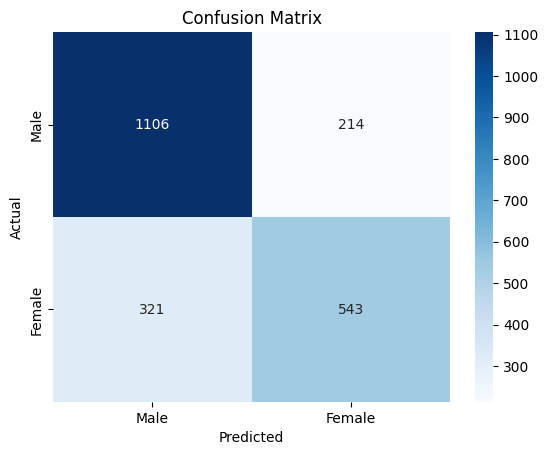

In [24]:
cm = confusion_matrix(augmented_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()